In [32]:
import os
import pandas as pd
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
from PIL import Image

# Load .env and set base directory
load_dotenv()
DATA_DIR = os.getenv("DATA_DIR")

# Paths to metadata files
ham_metadata_path = os.path.join(DATA_DIR, "dataverse_files", "HAM10000_metadata")
bcn_metadata_path = os.path.join(DATA_DIR, "bcn20000_metadata_2025-10-21.csv")



# Load HAM10000 metadata
ham_df = pd.read_csv(ham_metadata_path)

# Create mapping DataFrame
ham_hybrid_map = pd.DataFrame({
    'dx': [
        'nv',        # Melanocytic nevi
        'mel',       # Melanoma
        'bcc',       # Basal cell carcinoma
        'akiec',     # Actinic keratosis / intraepithelial carcinoma
        'vasc',      # Vascular lesion
        'df',        # Dermatofibroma
        'bkl'        # Benign keratosis-like lesions
    ],
    'diagnosis_hybrid': [
        'Nevus',                         # ✅ Merge with BCN
        'Melanoma (HAM)',               # ❌ Separate from BCN NOS/metastasis
        'Basal cell carcinoma',         # ✅ Merge with BCN
        'Actinic keratosis',            # ✅ Merge with BCN
        'Vascular lesion',              # ❌ HAM-only
        'Dermatofibroma',               # ✅ Merge with BCN
        'Benign keratosis (HAM)'        # ❌ Separate from BCN's seborrheic keratosis / solar lentigo
    ]
})

# Merge into ham_df
ham_df = ham_df.merge(ham_hybrid_map, on='dx', how='left')


# Load BCN20000 metadata
bcn_df = pd.read_csv(bcn_metadata_path)



## BCM Dataset

In [33]:
display(bcn_df.head())

,isic_id,attribution,copyright_license,age_approx,anatom_site_general,anatom_site_special,concomitant_biopsy,diagnosis_1,diagnosis_2,diagnosis_3,diagnosis_confirm_type,image_type,lesion_id,melanocytic,sex
0,ISIC_0053453,Hospital Clínic de Barcelona,CC-BY-NC,60.0,anterior torso,NaN,True,Benign,Benign melanocytic proliferations,Nevus,histopathology,dermoscopic,IL_0433332,True,male
1,ISIC_0053454,Hospital Clínic de Barcelona,CC-BY-NC,55.0,anterior torso,NaN,True,Malignant,Malignant melanocytic proliferations (Melanoma),"Melanoma, NOS",histopathology,dermoscopic,IL_8314504,True,male
2,ISIC_0053455,Hospital Clínic de Barcelona,CC-BY-NC,50.0,lower extremity,NaN,True,NaN,NaN,NaN,histopathology,dermoscopic,IL_8065011,NaN,male
3,ISIC_0053456,Hospital Clínic de Barcelona,CC-BY-NC,50.0,anterior torso,NaN,True,Malignant,Malignant melanocytic proliferations (Melanoma),"Melanoma, NOS",histopathology,dermoscopic,IL_5496448,True,female
4,ISIC_0053457,Hospital Clínic de Barcelona,CC-BY-NC,85.0,head/neck,NaN,True,Malignant,Malignant epidermal proliferations,"Squamous cell carcinoma, NOS",histopathology,dermoscopic,IL_7128083,False,male


In [34]:
display(bcn_df.groupby('diagnosis_3').size().reset_index(name='counts').sort_values(by='counts', ascending=False))

,diagnosis_3,counts
4,Nevus,5647
3,"Melanoma, NOS",4003
0,Basal cell carcinoma,3676
6,Seborrheic keratosis,1268
8,Solar or actinic keratosis,1088
2,Melanoma metastasis,633
9,"Squamous cell carcinoma, NOS",559
5,Scar,314
7,Solar lentigo,283
1,Dermatofibroma,168


## HAM Dataset

In [35]:
display(ham_df.head())

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,diagnosis_hybrid
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,Benign keratosis (HAM)
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,Benign keratosis (HAM)
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,Benign keratosis (HAM)
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,Benign keratosis (HAM)
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,Benign keratosis (HAM)


In [36]:
display(ham_df.groupby(['dx', 'diagnosis_hybrid']).size().reset_index(name='counts').sort_values(by='counts', ascending=False))

,dx,diagnosis_hybrid,counts
5,nv,Nevus,6705
4,mel,Melanoma (HAM),1113
2,bkl,Benign keratosis (HAM),1099
1,bcc,Basal cell carcinoma,514
0,akiec,Actinic keratosis,327
6,vasc,Vascular lesion,142
3,df,Dermatofibroma,115


## For Melanoma, see the difference between HAM and BCN

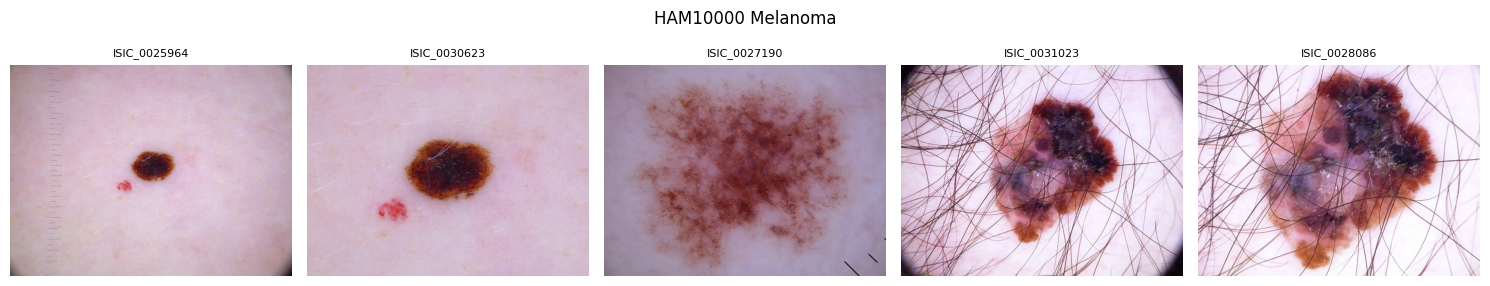

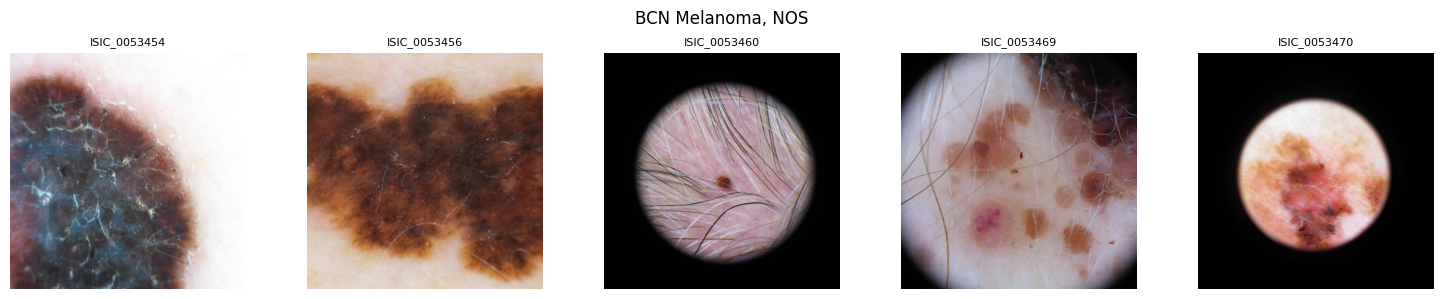

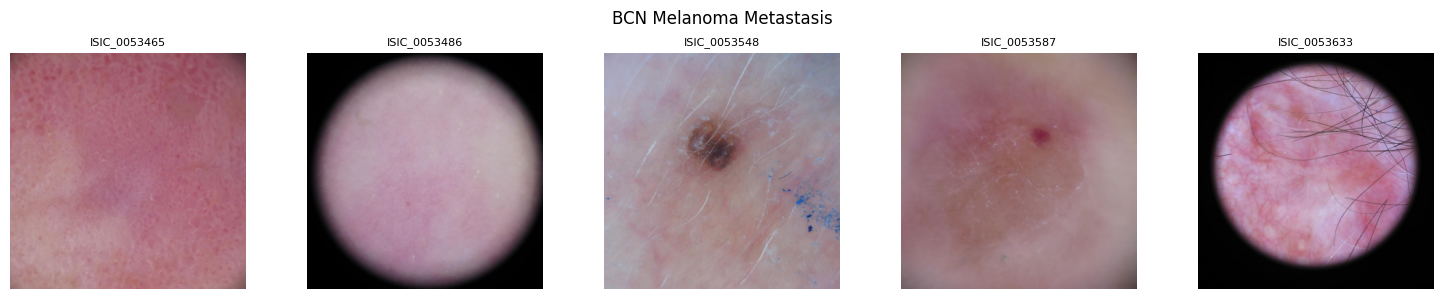

In [37]:
# Filter melanoma samples
ham_mel = ham_df[ham_df['dx'] == 'mel'].head(5)
bcn_mel_nos = bcn_df[bcn_df['diagnosis_3'] == 'Melanoma, NOS'].head(5)
bcn_mel_met = bcn_df[bcn_df['diagnosis_3'] == 'Melanoma metastasis'].head(5)

# Helper to find HAM image across both folders
def find_ham_image(image_id):
    for folder in ["HAM10000_images_part_1", "HAM10000_images_part_2"]:
        path = os.path.join(DATA_DIR, "dataverse_files", folder, f"{image_id}.jpg")
        if os.path.exists(path):
            return path
    return None

# General image display function
def show_images(df, finder_func, id_col='image_id', title=''):
    fig, axs = plt.subplots(1, len(df), figsize=(15, 3))
    for i, row in enumerate(df.itertuples()):
        img_path = finder_func(getattr(row, id_col))
        if img_path and os.path.exists(img_path):
            img = Image.open(img_path)
            axs[i].imshow(img)
            axs[i].axis('off')
            axs[i].set_title(getattr(row, id_col), fontsize=8)
        else:
            axs[i].text(0.5, 0.5, 'Missing', ha='center')
            axs[i].axis('off')
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

# Show samples
show_images(ham_mel, find_ham_image, title="HAM10000 Melanoma")
show_images(bcn_mel_nos, lambda x: os.path.join(DATA_DIR, "ISIC-images", f"{x}.jpg"), id_col='isic_id', title="BCN Melanoma, NOS")
show_images(bcn_mel_met, lambda x: os.path.join(DATA_DIR, "ISIC-images", f"{x}.jpg"), id_col='isic_id', title="BCN Melanoma Metastasis")